### Assignment 1

Submission should be in a Jupyter note book (.ipynb)

1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's compement for negative numbers. The function signature is 

   ```python
   def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
   # w: width of the binary representation
   # b: binary point
   ```
   Test the following inputs
   ```python
   fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0])
   ```
   ```python
   fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1])
   ```
   ```python
   fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1])
   ```
   


In [1]:
def fromFixedPoint(w: int, b:int, bits:[int]) -> float:
# w: width of the binary representation
# b: binary point
    y = 0
    for i in range(1, w):
        y += bits[i]*(2**(w-b-1-i))
       
    if bits[0] == 1:
        y = y - 2**(w-b-1)
        
    return y

In [2]:
print(fromFixedPoint(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0]))
print(fromFixedPoint(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1]))
print(fromFixedPoint(8, 2, [1, 0, 1, 0, 1, 0, 1, 1]))
print(fromFixedPoint(8, 1, [1, 1, 1, 0, 1, 1, 0, 0]))

44.75
-13.28125
-21.25
-10.0


2. Calculate the price of the following questions step by step using two step Cox Rox Rubinstein (CRR) Binomial tree

    a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$
    
    c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$
    
    What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)?
    

In [3]:
from enum import Enum
import math

class PayoffType(Enum):
    Call = 0
    Put = 1

In [4]:
def crrBinomial(S, r, vol, payoffType, K, T, n): 
    t = T/n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {
        PayoffType.Call: lambda s: max(s-K, 0),
        PayoffType.Put: lambda s: max(K-s, 0),
        }
    vs = [payoffDict[payoffType]( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

In [5]:
a = crrBinomial(100, 0.03, 0.2, PayoffType.Call, 105, 1, 2)
b = crrBinomial(100, 0.03, 0.2, PayoffType.Put, 105, 1, 2)

In [6]:
print("Value of Long a and Short b is:", a - b)

Value of Long a and Short b is: -1.8967810225933626


In [7]:
c = crrBinomial(100, 0.03, 0.1, PayoffType.Call, 105, 1, 2)
d = crrBinomial(100, 0.03, 0.1, PayoffType.Put, 105, 1, 2)

In [8]:
print("Value of Long c and Short d is:", c - d)

Value of Long c and Short d is: -1.8967810225933701


3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk
management. The commonly used greeks are:
    * Delta $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
    * Gamma $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
    * Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
    * Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to time.
    * Rho (PV01): the rate of change in the price of an option in response to a change in the interest rate.
    
  The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

    \begin{align}
    & \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S} \\
    & \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
    & v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S+\Delta \sigma) - V(S-\Delta \sigma)}{2 \Delta \sigma } \\
    & \theta = \frac{\partial V}{\partial t} \approx \frac{V(S+\Delta t) - V(S)}{\Delta t}
    \end{align}

  Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
      ```python
      def binomialGreeks(S, r, vol, T, strike, greekType) -> float
      ```
  Setting $S = 100, r = 0.03, vol = 0.2, T = 1$, plot each greeks as a function of strike from 50 to 150. Play with different binomial models and see if there is any difference.

In [9]:
#Black Scholes Model
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def bsPrice(S, r, vol, payoffType, K, T):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / K) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * K)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (K * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

In [10]:
from enum import Enum
import math

class PayoffType(Enum):
    Call = 0
    Put = 1

In [11]:
# binomial pricer for exercise 3
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]




In [12]:
#Greek Calculator using binomial tree pricer
class Greek(Enum):
    Delta = 0
    Gamma = 1
    Vega = 2
    Theta = 3
    
class GreekType():
    def __init__(self, payoffType, greek, calib, amer):
        self.payoffType = payoffType
        self.greek = greek
        self.calib = calib
        self.amer = amer

def binomialGreeks(S, r, vol, T, strike, greektype):
    dS = S*0.05
    dvol = vol*0.05
    dt = -0.05
    
    if greektype.amer == 0:
        opt = EuropeanOption(expiry = T, strike = strike, payoffType = greektype.payoffType)
        opt1 = EuropeanOption(expiry = T+dt, strike = strike, payoffType = greektype.payoffType)
        #Option details if T move down by 0.1%, this is to calculate Theta
    else:
        opt = AmericanOption(expiry = T, strike = strike, payoffType = greektype.payoffType)
        opt1 = AmericanOption(expiry = T+dt, strike = strike, payoffType = greektype.payoffType)
        #Option details if T move down by 0.1%, this is to calculate Theta
        
    VS = lambda S: binomialPricer(S, r, vol, opt, 500, greektype.calib)
    Vvol = lambda vol: binomialPricer(S, r, vol, opt, 500, greektype.calib)
    Vopt = lambda opt: binomialPricer(S, r, vol, opt, 500, greektype.calib)
   
    if greektype.greek == Greek.Delta:
        return (VS(S+dS)-VS(S-dS))/(2*dS)
    
    if greektype.greek == Greek.Gamma:
        return (VS(S+dS) - 2*VS(S) + VS(S-dS))/(dS**2)

    if greektype.greek == Greek.Vega:
        return (Vvol(vol+dvol)-Vvol(vol-dvol))/(2*dvol)
    
    if greektype.greek == Greek.Theta:
        return (Vopt(opt1)-Vopt(opt)) / dt
    
    else:
        print("GreekType not supported")

In [13]:
#Import Ploting Library
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
#Set Common Parameter
S, r, vol, T = 100, 0.03, 0.2, 1
strike_range = range(50,200)

### European Call Option

<Figure size 432x288 with 0 Axes>

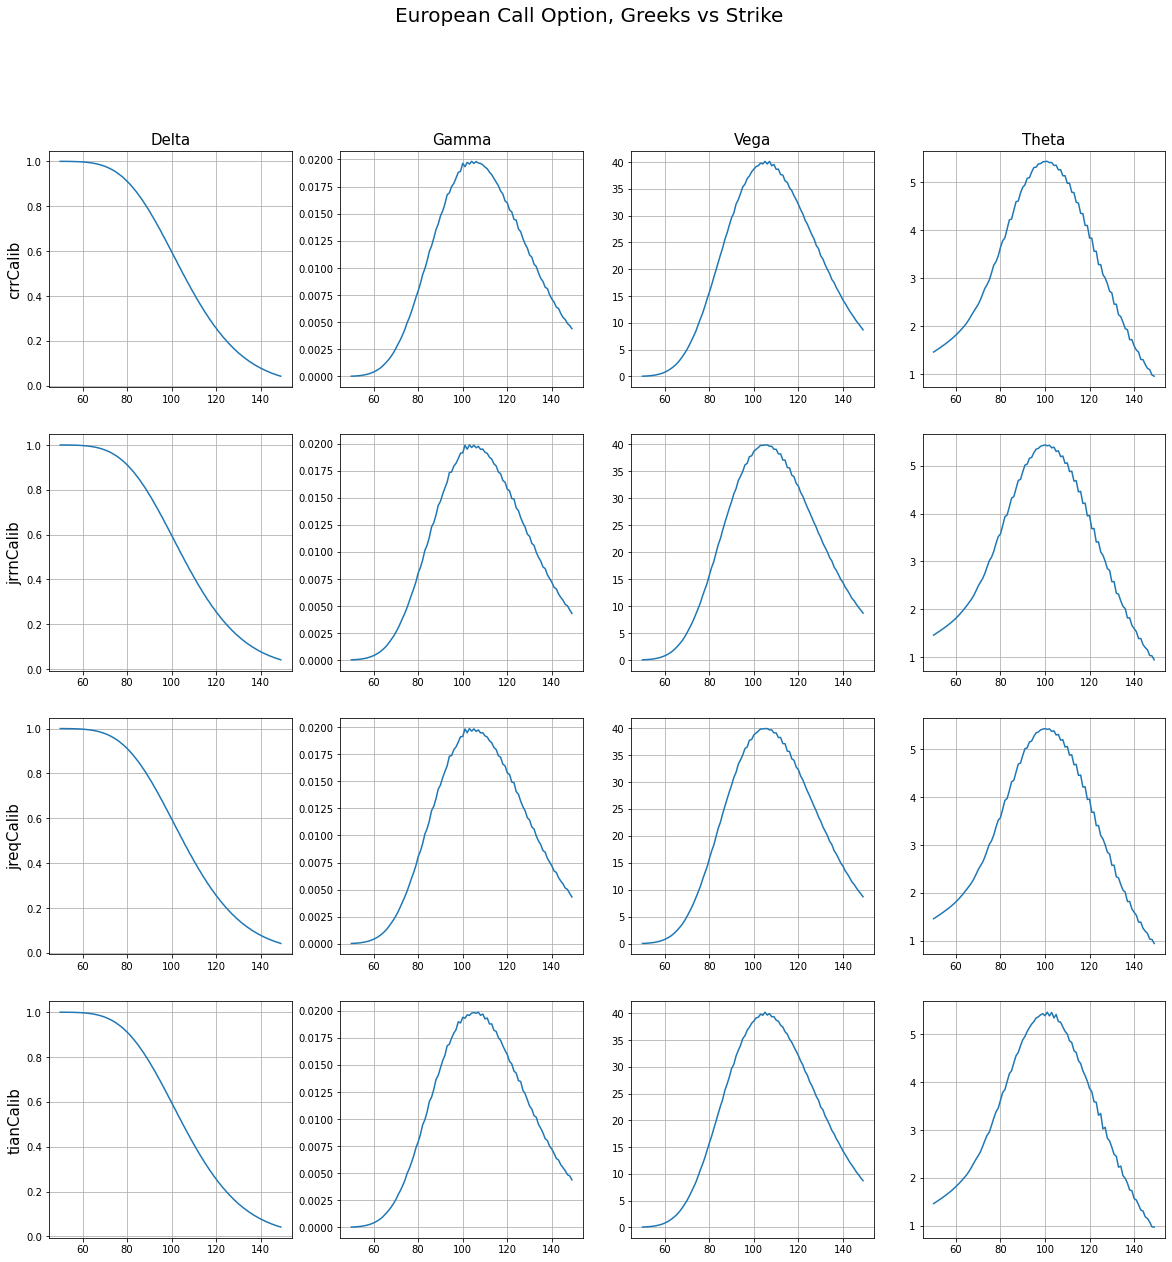

In [18]:
plt.figure()
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Delta", fontsize = 15)
plt.ylabel("crrCalib", fontsize = 15)

plt.subplot(4, 4, 2)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Gamma", fontsize = 15)

plt.subplot(4, 4, 3)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Vega", fontsize = 15)

plt.subplot(4, 4, 4)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Theta", fontsize = 15)

plt.subplot(4, 4, 5)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.ylabel("jrrnCalib", fontsize = 15)

plt.subplot(4, 4, 6)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 7)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 8)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 9)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("jreqCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 10)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 11)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 12)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 13)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("tianCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 14)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 15)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 16)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.suptitle("European Call Option, Greeks vs Strike", fontsize = 20)
plt.show()

### European Put Option

<Figure size 432x288 with 0 Axes>

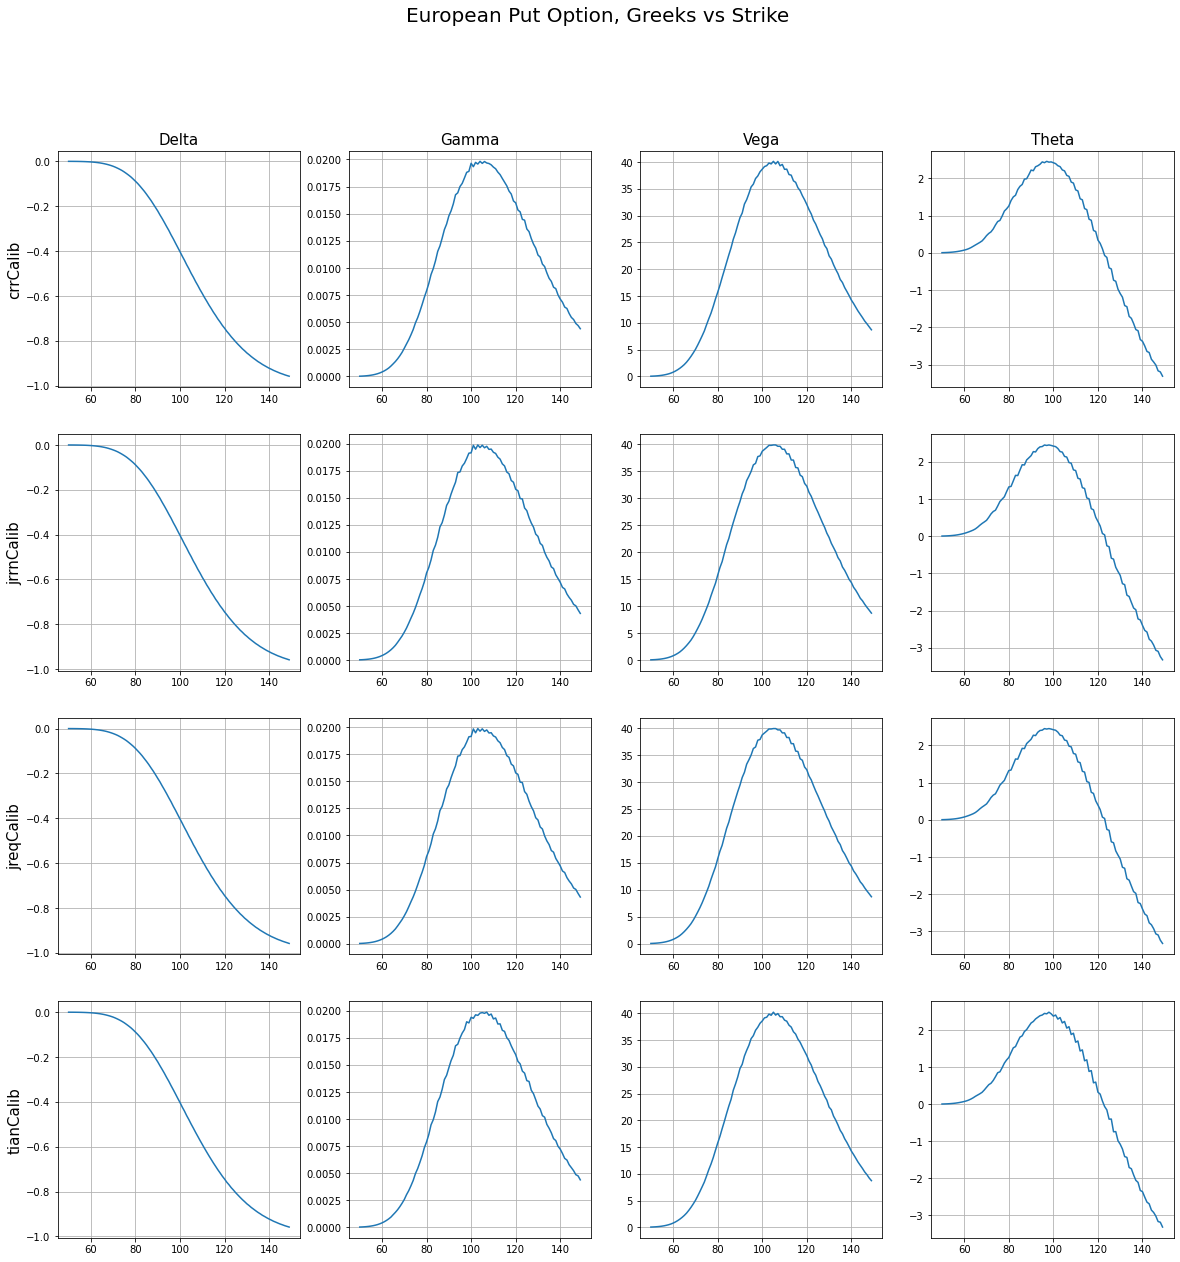

In [16]:
plt.figure()
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Delta", fontsize = 15)
plt.ylabel("crrCalib", fontsize = 15)

plt.subplot(4, 4, 2)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Gamma", fontsize = 15)

plt.subplot(4, 4, 3)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Vega", fontsize = 15)

plt.subplot(4, 4, 4)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = crrCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Theta", fontsize = 15)

plt.subplot(4, 4, 5)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.ylabel("jrrnCalib", fontsize = 15)

plt.subplot(4, 4, 6)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 7)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 8)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = jrrnCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 9)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("jreqCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 10)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 11)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 12)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = jreqCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 13)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("tianCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 14)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 15)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 16)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = tianCalib, amer=False)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.suptitle("European Put Option, Greeks vs Strike", fontsize = 20)
plt.show()


### American Call Option

<Figure size 432x288 with 0 Axes>

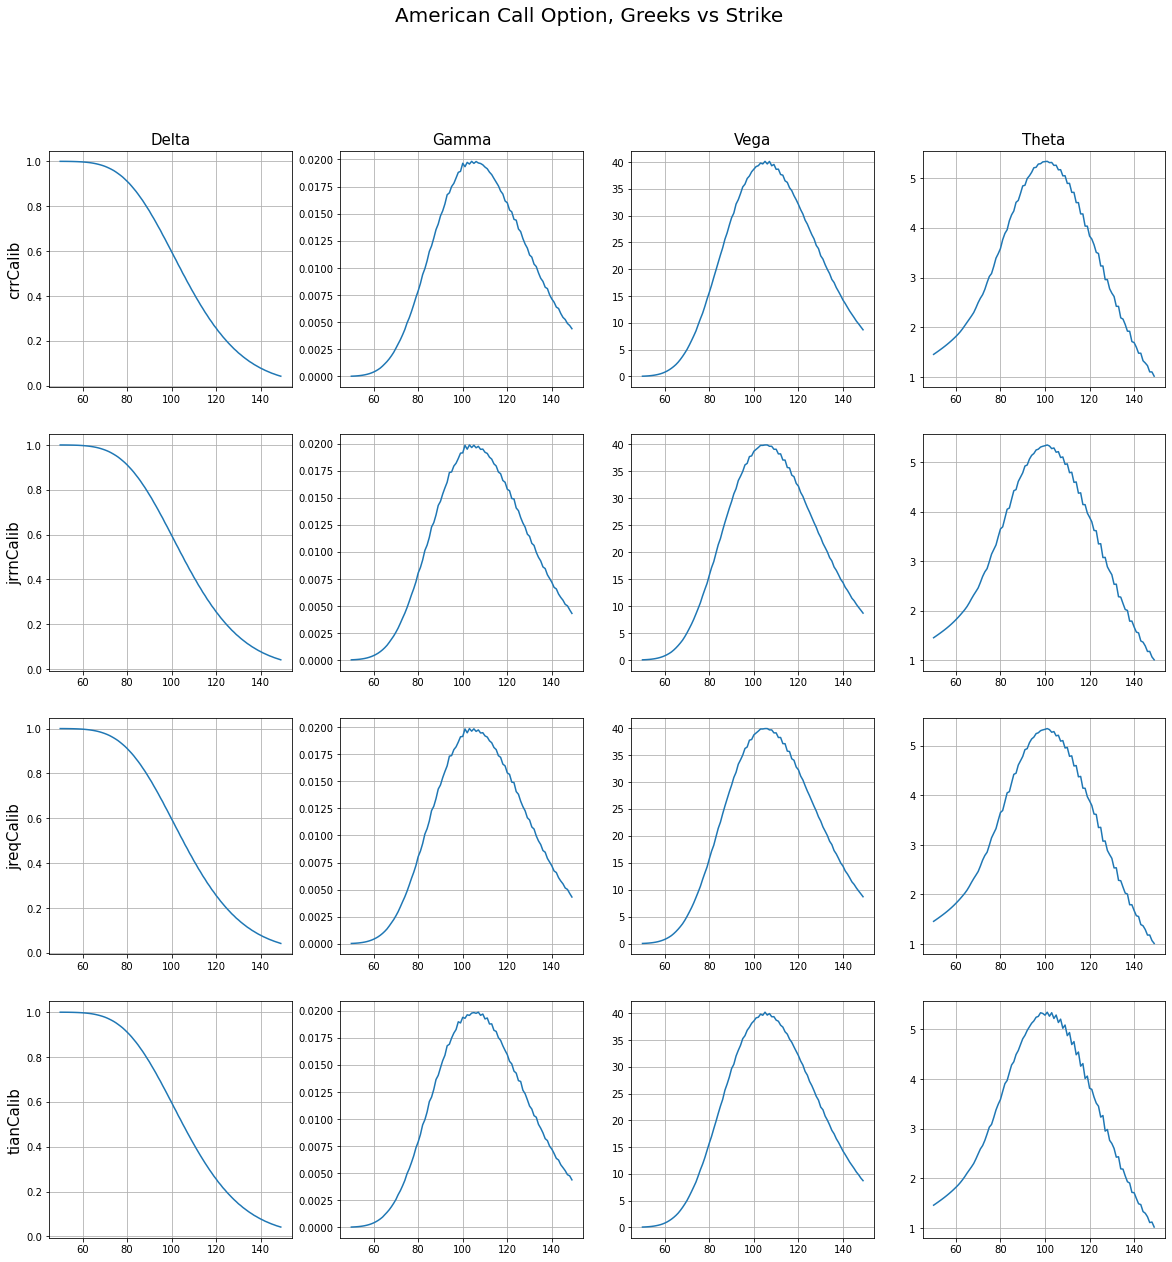

In [17]:
plt.figure()
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Delta", fontsize = 15)
plt.ylabel("crrCalib", fontsize = 15)

plt.subplot(4, 4, 2)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Gamma", fontsize = 15)

plt.subplot(4, 4, 3)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Vega", fontsize = 15)

plt.subplot(4, 4, 4)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Theta", fontsize = 15)

plt.subplot(4, 4, 5)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.ylabel("jrrnCalib", fontsize = 15)

plt.subplot(4, 4, 6)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 7)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 8)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 9)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("jreqCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 10)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 11)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 12)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 13)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("tianCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 14)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Gamma, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 15)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Vega, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 16)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Theta, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.suptitle("American Call Option, Greeks vs Strike", fontsize = 20)
plt.show()


### American Put Option

<Figure size 432x288 with 0 Axes>

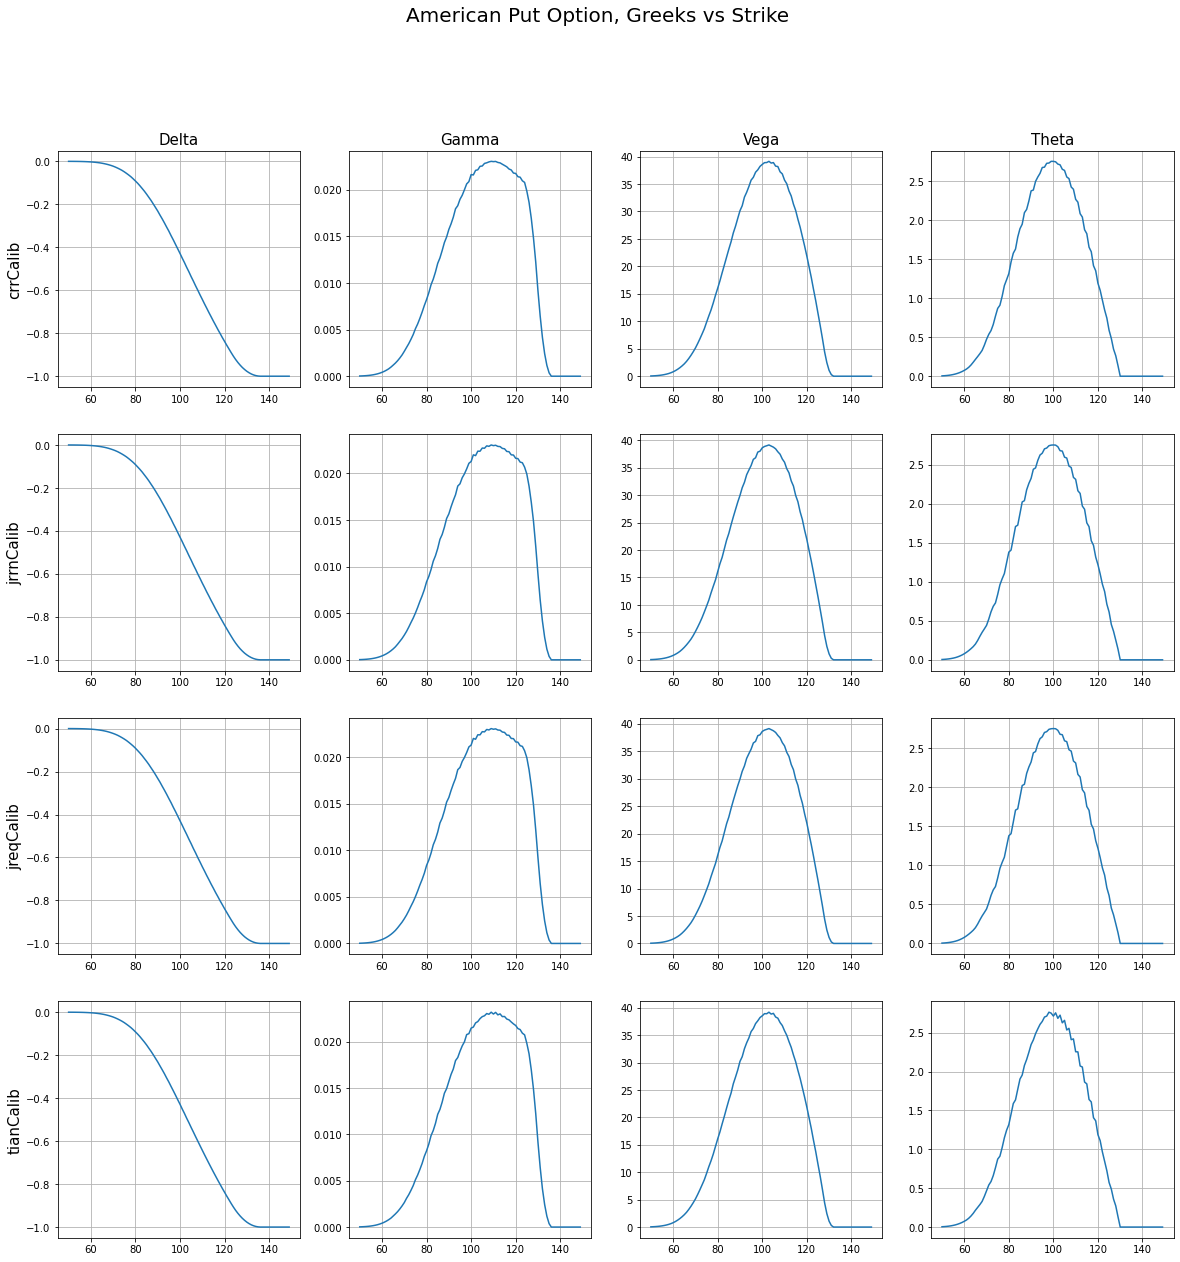

In [18]:
plt.figure()
plt.figure(figsize=(20,20))

plt.subplot(4, 4, 1)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Delta", fontsize = 15)
plt.ylabel("crrCalib", fontsize = 15)

plt.subplot(4, 4, 2)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Gamma", fontsize = 15)

plt.subplot(4, 4, 3)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Vega", fontsize = 15)

plt.subplot(4, 4, 4)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = crrCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.title("Theta", fontsize = 15)

plt.subplot(4, 4, 5)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)
plt.ylabel("jrrnCalib", fontsize = 15)

plt.subplot(4, 4, 6)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 7)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 8)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = jrrnCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 9)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("jreqCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 10)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 11)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 12)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = jreqCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 13)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Delta, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("tianCalib", fontsize = 15)
plt.grid(True)

plt.subplot(4, 4, 14)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Gamma, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 15)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Vega, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.subplot(4, 4, 16)
Specification = GreekType(payoffType = PayoffType.Put, greek = Greek.Theta, calib = tianCalib, amer=True)
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.grid(True)

plt.suptitle("American Put Option, Greeks vs Strike", fontsize = 20)
plt.show()


In [33]:
def binomialPricerX(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.valueAtNode(trade.expiry, S * u ** (n - i) * d ** i, 0) for i in range(n + 1)]
    numStates = len([vs[0]])
    return numStates

In [20]:
class KnockInOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def triggerBarrier(self, t, S):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return True
            elif self.downBarrier != None and S < self.downBarrier:
                return True
        return False
    # for knock-in options we define two states,
    # first state is the option value if the knock-in is not triggered in previous steps
    # second state is the option value if the knock-in has been triggered
    # and we merged payoff function, if continuation is none then it's the last time step
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            notKnockedInTerminalValue = 0
            if self.triggerBarrier(t, S):  # if the trade is not knocked in,
                # it is still possible to knock in at the last time step
                notKnockedInTerminalValue = self.underlyingOption.payoff(S)
                # if the trade is knocked in already
            knockedInTerminalValue = self.underlyingOption.payoff(S)
            return [notKnockedInTerminalValue, knockedInTerminalValue]
        else:
            nodeValues = continuation
            # calculate state 0: if no hit at previous steps
            if self.triggerBarrier(t, S):
                nodeValues[0] = continuation[1]
            # otherwise just carrier the two continuation values
        return nodeValues

In [24]:
def binomialGreeks(S, r, vol, T, strike, greektype):
    dS = S*0.05
    dvol = vol*0.05
    dt = -0.05
    
    if greektype.amer == 0:
        opt = EuropeanOption(expiry = T, strike = strike, payoffType = greektype.payoffType)
        opt1 = EuropeanOption(expiry = T+dt, strike = strike, payoffType = greektype.payoffType)
        #Option details if T move down by 0.1%, this is to calculate Theta
    
    elif greektype.amer == "UIC":
        opt_1 = EuropeanOption(expiry = T, strike = strike, payoffType = greektype.payoffType)
#        opt1 = EuropeanOption(expiry = T+dt, strike = strike, payoffType = greektype.payoffType)        
        opt = KnockInOption(downBarrier =None, upBarrier = 130, barrierStart=0.1, barrierEnd=T, underlyingOption = opt_1)
    
    else:
        opt = AmericanOption(expiry = T, strike = strike, payoffType = greektype.payoffType)
        opt1 = AmericanOption(expiry = T+dt, strike = strike, payoffType = greektype.payoffType)
        #Option details if T move down by 0.1%, this is to calculate Theta
        
    VS = lambda S: binomialPricer(S, r, vol, opt, 500, greektype.calib)
    Vvol = lambda vol: binomialPricer(S, r, vol, opt, 500, greektype.calib)
    Vopt = lambda opt: binomialPricer(S, r, vol, opt, 500, greektype.calib)
   
    if greektype.greek == Greek.Delta:
        return (VS(S+dS)-VS(S-dS))/(2*dS)
    
    if greektype.greek == Greek.Gamma:
        return (VS(S+dS) - 2*VS(S) + VS(S-dS))/(dS**2)

    if greektype.greek == Greek.Vega:
        return (Vvol(vol+dvol)-Vvol(vol-dvol))/(2*dvol)
    
#    if greektype.greek == Greek.Theta:
#        return (Vopt(opt1)-Vopt(opt)) / dt
    
    else:
        print("GreekType not supported")

In [25]:
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.underlyingOption.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [27]:
S, r, vol, T = 100, 0.03, 0.2, 2
strike_range = range(50,200)
Specification = GreekType(payoffType = PayoffType.Call, greek = Greek.Delta, calib = tianCalib, amer="UIC")
plt.plot(strike_range, [binomialGreeks(S, r, vol, T, strike, Specification) for strike in strike_range])
plt.ylabel("crrCalib", fontsize = 15)
plt.grid(True)

TypeError: 'float' object is not subscriptable